# Notebook for analysing all VR trials of one experimental group; 2-object forest
## Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [281]:
__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVROptogenTrialAnalysis

from plottingUtilities.basicPlotting import makeNestedPlotDirectory, myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import residencyWithHistograms_splitOnWalking, residencyWithHistograms,\
        radDistAngleCombiPlot, plotResidencyInMiniarena, make4ValuePolCoordPlot, oneDimResidencyWithVar_df
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, plotVeloHeadingDistribution2_flyVR_df,\
                               oneDimResidency_df, turnRatePerDistance, oneDimResidencyWithVar_2LM_df

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec, RayleighTest, fractional_polar_axes

from flyVR.utilities.loadSingleTrial import rZoneParamsFromLogFile

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [282]:
expDirs=expDirs[:]
expDirs

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07']

In [283]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#from operator import itemgetter
#my_indices = [7,8,9,10]#[0,2,4,6,7,8,9,10,11,12]
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''  # chose small string, to specify dataset (e.g. top5 flies)

In [284]:
%matplotlib inline

### Compose mutli-fly data into dataframe

In [285]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [286]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [287]:
starvation = dataDir.split(sep)[-3]
starvation

'starved'

In [288]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','starvation','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsPr = 0
nTrialsTr = 0
nTrialsPo = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[6]
        stimT = fileToAnalyse.split('_')[-4]
        
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
            nTrialsTr += 1
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
            nTrialsPr += 1
        else:
            trialtype = 'post'
            rZones = 'off'
            nTrialsPo += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'starvation', starvation)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/humidityNotCtrld/male/cylinder/starved/rawData/m01/

 Analysing the following log files:

['twoObjectForest_1cm4cmCyliz1R_08cm3cmConez2_6cmGrid_4-5d_12h_m01_200ms_post_out_170731115820.txt', 'twoObjectForest_1cm4cmCyliz1R_08cm3cmConez2_6cmGrid_4-5d_12h_m01_200ms_pre_out_170731112618.txt', 'twoObjectForest_1cm4cmCyliz1R_08cm3cmConez2_6cmGrid_4-5d_12h_m01_200ms_train_out_170731113734.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr43a-KI_x_10xChrimsonR/humidityNotCtrld/male/cylinder/starved/rawData/m02/

 Analysing the following log files:

['twoObjectForest_1cm4cmCyliz1R_08cm3cmConez2_6cmGrid_4-5d_12h_m02_200ms_post_out_170731215018.txt', 'twoObjectForest_1cm4cmCyliz1R_08cm3cmConez2_6cmGrid_4-5d_12h_m02_200ms_pre_out_1707

In [289]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,reinforcement,starvation,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,m01,1.0,post,off,starved,1.0,-0.000004,-0.235487,0.000000,1.211257e+07,473021.000000,NaN,-377712.000000,NaN,0.0
1,m01,1.0,post,off,starved,1.0,-0.011781,-0.235564,0.050012,1.048750e+01,-351.100144,8.899856,281.009112,41.009112,0.0
2,m01,1.0,post,off,starved,1.0,-0.023562,-0.392606,0.100024,7.974990e+00,-350.576388,9.423612,280.981184,40.981184,0.0
3,m01,1.0,post,off,starved,1.0,-0.043197,-0.078521,0.150036,7.875546e+00,-350.200092,9.799908,281.113387,41.113387,0.0
4,m01,1.0,post,off,starved,1.0,-0.047124,-0.157042,0.200047,1.126434e+01,-349.811409,10.188591,281.177102,41.177102,0.0
5,m01,1.0,post,off,starved,1.0,-0.054978,-0.157042,0.250059,7.046114e+00,-349.248154,10.751846,281.187438,41.187438,0.0
6,m01,1.0,post,off,starved,1.0,-0.062832,-0.706691,0.300071,2.617573e+00,-348.897551,11.102449,281.152000,41.152000,0.0
7,m01,1.0,post,off,starved,1.0,-0.098175,-2.277115,0.350083,3.156230e+00,-348.835001,11.164999,281.037001,41.037001,0.0
8,m01,1.0,post,off,starved,1.0,-0.212058,-3.038278,0.400095,3.807932e+00,-348.801368,11.198632,280.882777,40.882777,0.0
9,m01,1.0,post,off,starved,1.0,-0.364007,-3.099189,0.450107,3.882494e+00,-348.730705,11.269295,280.705930,40.705930,0.0


In [290]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [291]:
# Two object reinforcement test
rZoneState = ['off','on','off']
visibilityState = ['visible','visible','visible']
groundPlane = ['texture','texture','texture']
trialName = ['pre','train','post']
gridSize = 60.0

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'

#rZone_rInner, rZone_rOuter, rZone_max, rZone_gExp = rZoneParamsFromLogFile(expDir, fileToAnalyse)

In [292]:
visitRad = 15
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

### Trajectory plots of all trials

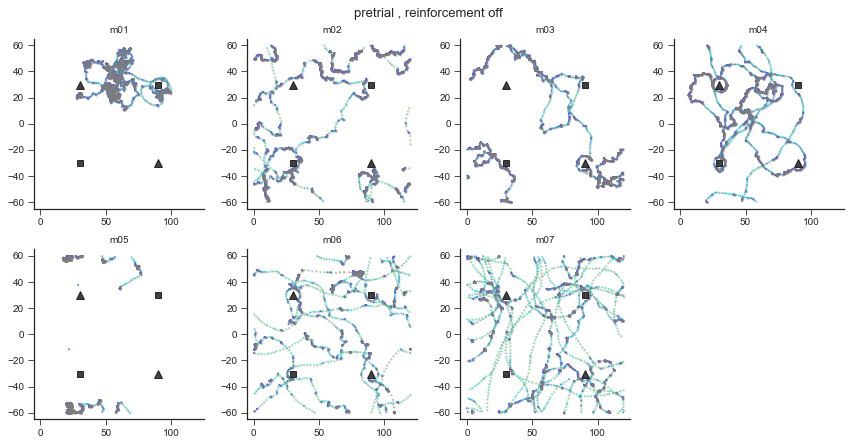

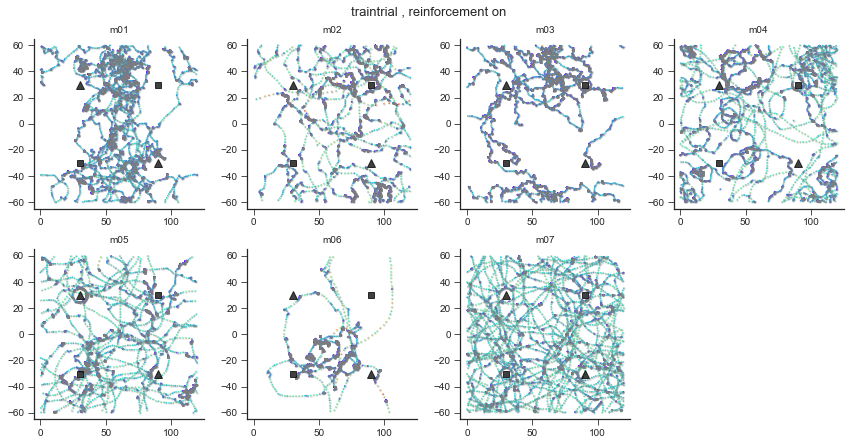

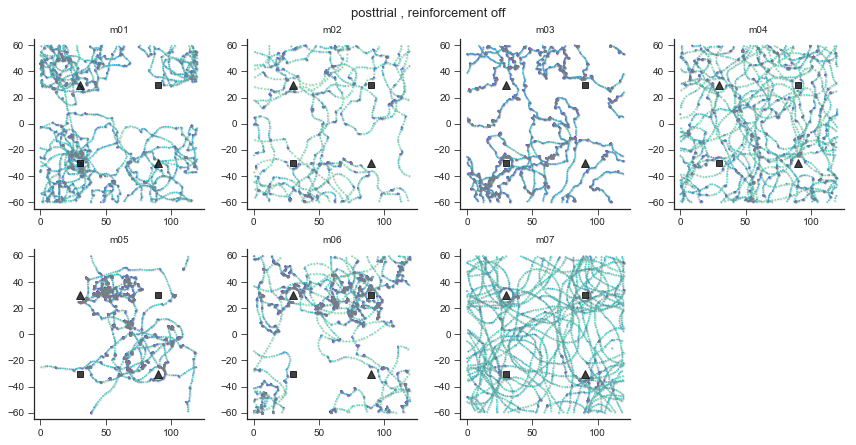

In [293]:
nrows = np.ceil(numFlies/4.0)
for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + 'trial , reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        
        selectPts = range(0,len(perFlyX),3)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        if (visibilityState[ttind] == 'visible'):
            multiflyTracePlot_sbplt.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.75, color='black')
            multiflyTracePlot_sbplt.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.75, color='black')
        else:
            multiflyTracePlot_sbplt.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=cyliColor)
            multiflyTracePlot_sbplt.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=coneColor)
            multiflyTracePlot_sbplt.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=coneColor)
            multiflyTracePlot_sbplt.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor=cyliColor)
        #if(rZoneState[ttind]=='on'):
        #    rZoneRange = float(rZone_rOuter - rZone_rInner)
        #    for zRad in range(rZone_rInner, rZone_rOuter):
        #        circle1 = plt.Circle((0, 0), zRad, color='r', alpha=1.0/rZoneRange)
        #        multiflyTracePlot_sbplt.add_artist(circle1)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-5, gridSize*2 + 5)
        multiflyTracePlot_sbplt.set_ylim(-5-gridSize, gridSize + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_trial'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Residency

### 2D (cartesian) residency

Plot directory already exists


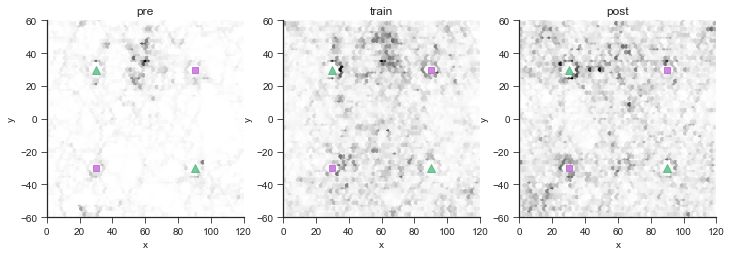

In [294]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    
    ax.plot(gridSize/2, -gridSize/2, marker='s', markersize=6, alpha=0.7, color=cyliColor)
    ax.plot(gridSize/2, gridSize/2, marker='^', markersize=8, alpha=0.7, color=coneColor)
    ax.plot(3*gridSize/2, -gridSize/2, marker='^', markersize=8, alpha=0.7, color=coneColor)
    ax.plot(3*gridSize/2, gridSize/2, marker='s', markersize=6, alpha=0.7, color=cyliColor)
            
    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    ax.set_aspect('equal')
    myAxisTheme(ax)
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [295]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        
        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

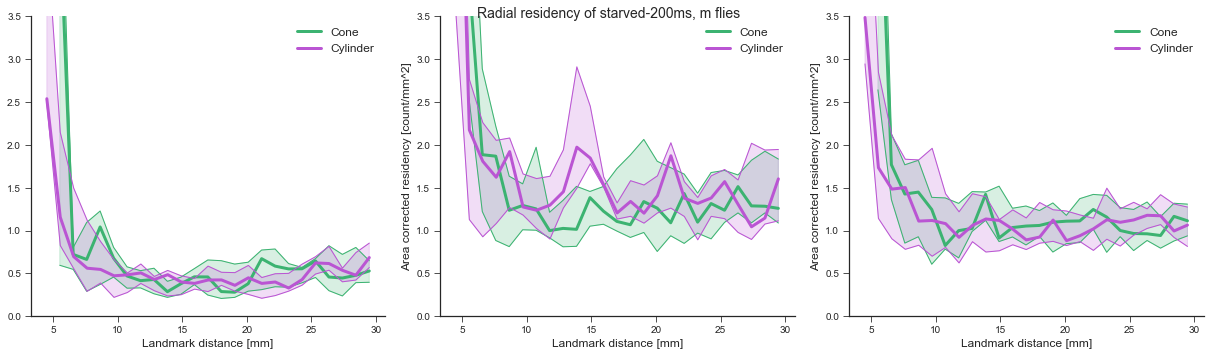

In [296]:
movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,4) # adjust to LM base width
numBins = (25, 26)
varStyle = 'iqr' #'std', 'iqr'

LMcols = [coneColor,cyliColor]
LMnames = ['Cone', 'Cylinder']

keyind_dCone = resdf_keylist.index('dist2cone')
keyind_dCyli = resdf_keylist.index('dist2cyli')

# linear residency
radResFig = plt.figure(figsize=(17,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residency_df, flyIDs, trialName,keyind_dCone, keyind_dCyli,
                                          movementFilter, numBins, histMin, histMax, 1, varStyle, LMcols, LMnames)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Effect of reinforcement on walking velocity

Plot directory already exists


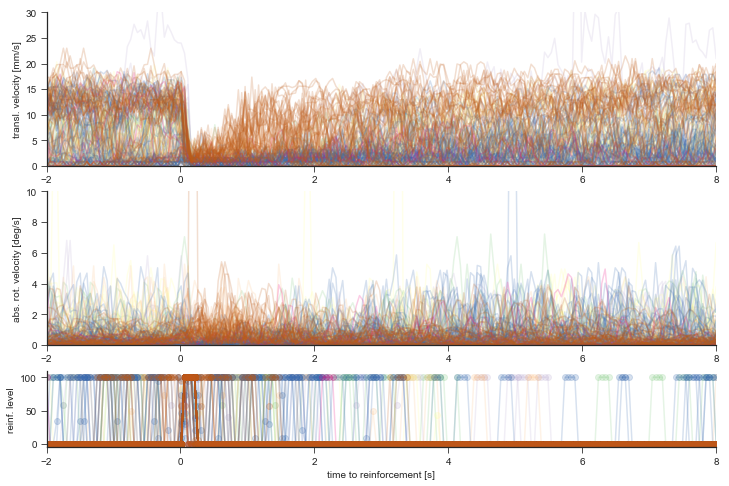

In [304]:
trialtype ='train'

fps = 20.0
 
rewardEffectFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,1,height_ratios=[1,1,0.5])

rewardVTPlt = rewardEffectFig.add_subplot(gs[0])
rewardVRPlt = rewardEffectFig.add_subplot(gs[1])
rewardEVPlt = rewardEffectFig.add_subplot(gs[2])
    
for fly in range(numFlies):
    flyCol = flyCMap.to_rgba(fly)
    querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

    perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].values.squeeze()
    perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
    perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
    perFlyEv = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

    evTimes = np.where(perFlyEv>80)[0]
    evStarts = np.where(np.diff(perFlyEv)>0)[0]

    postWindow = 160
    preWindow = 40
    timeLine = np.linspace(-preWindow*1/fps,postWindow*1/fps,preWindow+postWindow)
    for evStart in evStarts:
        evStart = evStart
        if (evStart+postWindow > len(perFlyvT) or evStart-preWindow < 0):
            continue
        rewardVTPlt.plot(timeLine,perFlyvT[evStart-preWindow:evStart+postWindow],color=flyCol,alpha=0.2)
        rewardVRPlt.plot(timeLine,abs(perFlyvR[evStart-preWindow:evStart+postWindow]),color=flyCol,alpha=0.2)
        rewardEVPlt.plot(timeLine,perFlyEv[evStart-preWindow:evStart+postWindow],'o-',color=flyCol,alpha=0.2)

rewardVTPlt.set_ylim(0,30)
rewardVTPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVTPlt.set_ylabel('transl. velocity [mm/s]')
myAxisTheme(rewardVTPlt)

rewardVRPlt.set_ylim(0,10)
rewardVRPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVRPlt.set_ylabel('abs. rot. velocity [deg/s]')
myAxisTheme(rewardVRPlt)

rewardEVPlt.set_ylim(-5,110)
rewardEVPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardEVPlt.set_ylabel('reinf. level')
rewardEVPlt.set_xlabel('time to reinforcement [s]')
myAxisTheme(rewardEVPlt)


try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
rewardEffectFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                   +'_velocityRespToReinf_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Visit-based analysis

In [305]:
def countvisits(dist2Obj,visitRad):
    
    inside = (dist2Obj<visitRad).astype('int')
    time = np.linspace(0,600,len(dist2Obj))

    entries = np.zeros(len(inside))
    entries[1:] = np.diff(inside) == 1

    exits = np.zeros(len(inside))
    exits[1:] = np.diff(inside) == -1
    
    #check if no entries and/or no exits
    if len(inside)==0 or sum(np.diff(inside) == -1)<1:
        visitT = entryTime = exitTime = np.nan
        return entries, exits, visitT, entryTime, exitTime

    entryTime = time[entries.astype('bool')]
    exitTime = time[exits.astype('bool')]
    
    if len(entryTime) == len(exitTime):
        visitT = exitTime - entryTime
    else:
        visitT = exitTime[0:min(sum(exits),sum(entries)).astype('int')] - entryTime[0:min(sum(exits),sum(entries)).astype('int')]
        
    return entries, exits, visitT, entryTime, exitTime

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


Plot directory already exists
Plot directory already exists
Plot directory already exists
Plot directory already exists


/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice


no cylinder visits detected
Plot directory already exists
Plot directory already exists
Plot directory already exists


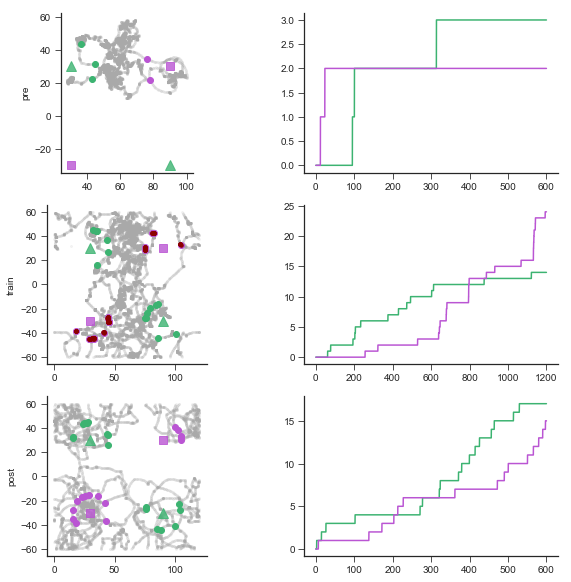

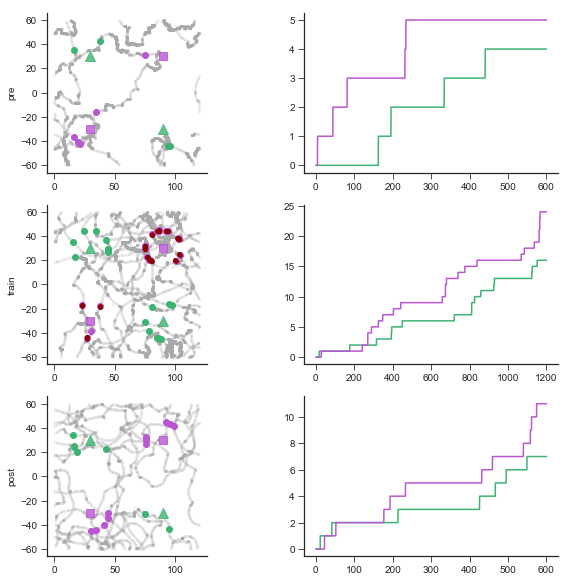

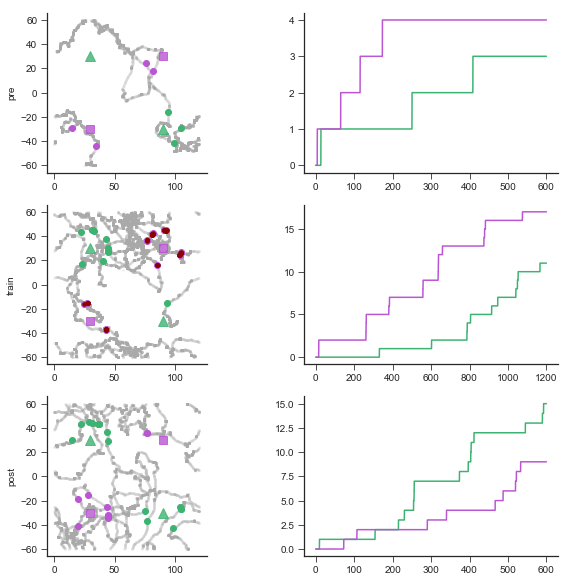

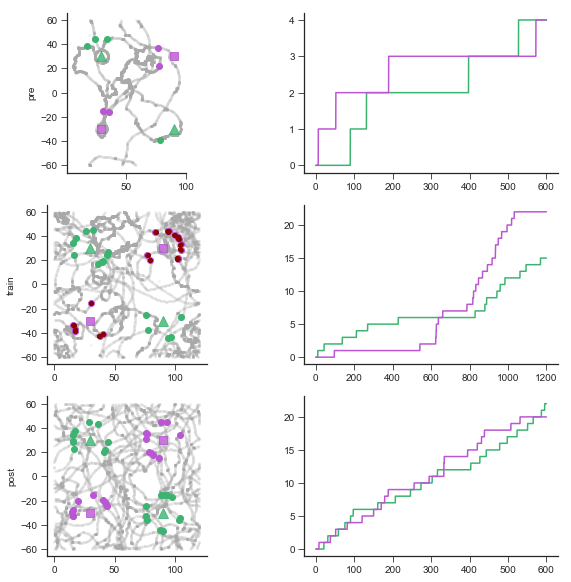

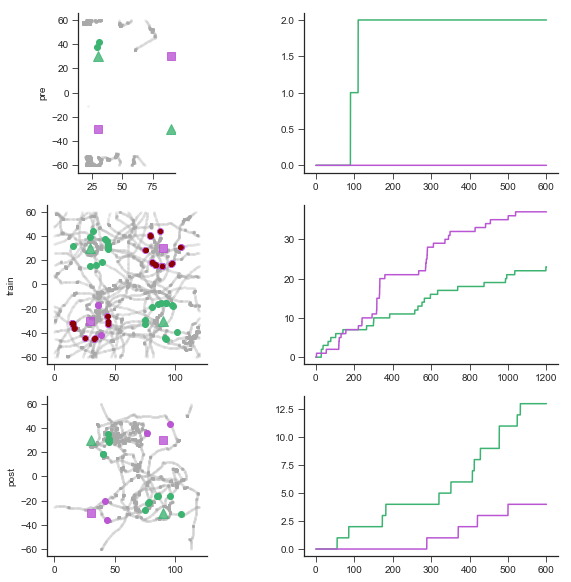

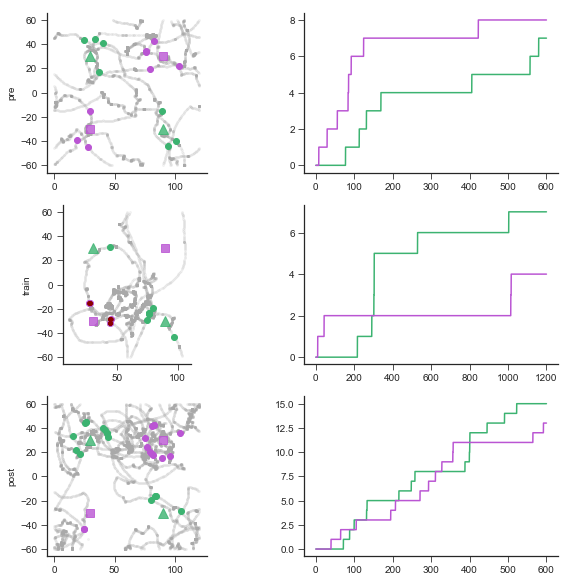

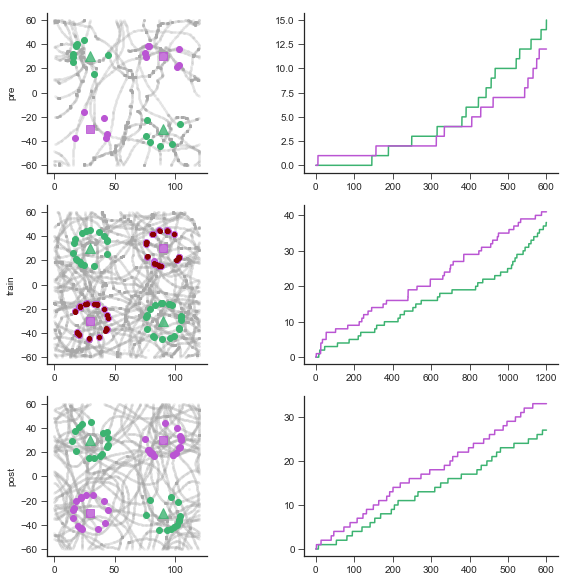

In [306]:
coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

coneFirstVisit = np.zeros((len(flyIDs),len(trialName)))
cyliFirstVisit = np.zeros((len(flyIDs),len(trialName)))

coneVisitLength = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLength = np.zeros((len(flyIDs),len(trialName)))

coneVisitLengthAV = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLengthAV = np.zeros((len(flyIDs),len(trialName)))


for fly in range(len(flyIDs)):
    visitFig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(len(trialName),2,width_ratios=[1,1])


    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)

        visitPlt = visitFig.add_subplot(gs[trial,0])
        visitPlt.plot(xPosTrial,yPosTrial,'.',color='darkgrey',markersize=4,alpha=0.1)
        visitPlt.plot(xPosTrial[entriesCone>0],yPosTrial[entriesCone>0],'o',color=coneColor)
        visitPlt.plot(xPosTrial[entriesCyli>0],yPosTrial[entriesCyli>0],'o',color=cyliColor)
        
        visitPlt.plot(xPosTrial[evTrial>0],yPosTrial[evTrial>0],'.',markersize=7,color='darkred')

        for obj in range(2):
            visitPlt.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
            visitPlt.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)

        visitPlt.set_aspect('equal')
        visitPlt.set_ylabel(trialtype)
        myAxisTheme(visitPlt)

        cumsumVisitPlt = visitFig.add_subplot(gs[trial,1])
        cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCone),color=coneColor)
        cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCyli),color=cyliColor)
        myAxisTheme(cumsumVisitPlt)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)
        
        coneVisitLength[fly,trial] = np.sum(visitTCone)
        cyliVisitLength[fly,trial] = np.sum(visitTCyli)
        
        coneVisitLengthAV[fly,trial] = np.nanmean(visitTCone)
        cyliVisitLengthAV[fly,trial] = np.nanmean(visitTCyli)
        
        try:
            coneFirstVisit[fly,trial] = visitTCone[0]
        except:
            print('no cone visits detected')
            coneFirstVisit[fly,trial] = np.nan
        
        try:
            cyliFirstVisit[fly,trial] = visitTCyli[0]
        except:
            print('no cylinder visits detected')
            cyliFirstVisit[fly,trial] = np.nan


    try:
        mkdir(analysisDir + 'reinforcementEffect/')
    except:
        print('Plot directory already exists')
    visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

### Helper functions for plotting

In [307]:
def prettyBoxPlot(bpPlt, myBoxCols, objtype, myObjVals, flyIDs, offsets, plotLabels):
    # myObjVals should be e.g. VisitCount[objtype], myBoxCols should be objBoxColors[objtype]
    
    boxs = bpPlt.boxplot(myObjVals,patch_artist=True)
    plt.setp(boxs['whiskers'], color='black',linestyle='-')
    plt.setp(boxs['medians'], color='black',linewidth=2)
    plt.setp(boxs['fliers'], color='grey', marker='+')
    
    jitter = np.random.normal(0, 0.012*len(offsets), size=len(myObjVals[:,0]))
             
    for ind,box in enumerate(boxs['boxes']):
        plt.setp(box,color=myBoxCols[ind],linewidth=1.5,alpha=boxalpha)
        boxprops = dict(linestyle='-', linewidth=1.5, color='grey')

        # Add some random "jitter" to the x-axis
        x = ind+jitter+offsets[ind]
        bpPlt.plot(x, myObjVals[:,ind], 'o', color=myBoxCols[ind], alpha=0.8)
    
    for fly in range(len(flyIDs)):
        if len(offsets)<3:
            trialOffSets = np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1]))
        else:
            trialOffSets = np.vstack((np.vstack((0+jitter[fly]+offsets[0],1+jitter[fly]+offsets[1])),
                                      2+jitter[fly]+offsets[2]))
        bpPlt.plot(trialOffSets, myObjVals[fly,:], '-', color='grey', linewidth = 0.5, alpha=linealpha)
        
        if plotLabels:
            bpPlt.text(len(offsets)-.91+jitter[fly]+offsets[-1], myObjVals[fly,-1],flyIDs[fly])
    
    if len(offsets)<3:
        plt.xticks(range(1,len(trialName)),[trialName[0],trialName[2]])
    else:
        plt.xticks(range(1,len(trialName)+1),trialName)
    bpPlt.axhline(y=0, linewidth=1,color='grey', linestyle='dashed')
    bpPlt.set_ylim((-0.1*np.max(myObjVals),(0.1*np.max(myObjVals))+np.max(myObjVals)))
    myAxisTheme(bpPlt)
    
    return bpPlt

In [308]:
def diffCorrPlot(bpPlt, prePostDiffVals, flyIDs, dotcol):
    from scipy.stats.stats import pearsonr

    bpPlt.scatter(prePostDiffVals[:,0],prePostDiffVals[:,1],s=30,facecolor=dotcol)
    for fly in range(len(flyIDs)):
        bpPlt.text(prePostDiffVals[fly,0]+0.03,prePostDiffVals[fly,1]+0.03,flyIDs[fly])

    rsq, p = pearsonr(prePostDiffVals[:,0],prePostDiffVals[:,1])
    bpPlt.set_xlabel('Delta pre')
    bpPlt.set_ylabel('Delta post')
    bpPlt.axhline(y=0, linewidth=1,color='grey', linestyle='dashed')
    bpPlt.axvline(x=0, linewidth=1,color='grey', linestyle='dashed')
    minplt = -0.5+np.min(prePostDiffVals)
    maxplt = 0.5+np.max(prePostDiffVals)
    bpPlt.plot([minplt,maxplt], [minplt,maxplt],linewidth=1,color=dotcol,alpha=0.3)
    bpPlt.set_title('correlation: PCC='+str(round(rsq,4))+', p='+str(round(p,4)))
    bpPlt.set_xlim((minplt,maxplt))
    bpPlt.set_ylim((minplt,maxplt))
    myAxisTheme(bpPlt)
    
    return bpPlt

### Shared settings for plots

In [309]:
# Settings for boxplots of all three trials:

objtypeNames = ['Cone','Cylinder']

objBoxColors = [['lightgreen','seagreen','mediumseagreen'],
                ['palevioletred','darkmagenta','mediumorchid']] #for spec. objects
# [['tomato','red','tomato'],['steelblue','blue','steelblue']]
BoxColors = ['grey','slateblue','royalblue'] # for ratio between objects
# ['grey','darkred','grey']

trialColors = ['darkseagreen', 'darkviolet','teal']
trialMarkers = ['d','*','o']

offsets = [1.3, 1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

In [310]:
# Settings for boxplots of pre and post trial only
objBoxColors_pp = [['lightgreen','mediumseagreen'],
                   ['palevioletred','mediumorchid']]
BoxColors_pp = ['grey','royalblue'] 
offsets_pp = [1.32, 0.68]

### Visit count

Plot directory already exists


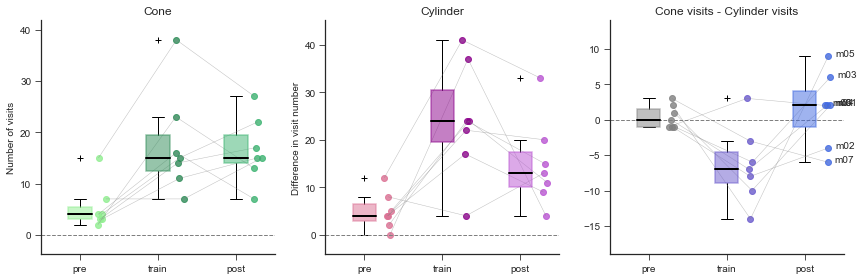

In [311]:
bpFig = plt.figure(figsize=allTrialFigSize)

VisitCount = [coneVisitCount,cyliVisitCount]
VisitCountRatio = coneVisitCount-cyliVisitCount

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], objtype, VisitCount[objtype], 
                              flyIDs, offsets, plotLabels=False)

    objBoxPlt.set_ylabel('Number of visits')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, objtype, VisitCountRatio, flyIDs, offsets, plotLabels=True)

bpPlt.set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
objBoxPlt.set_ylabel('Difference in visit number')
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit frequency [1/min]

Plot directory already exists


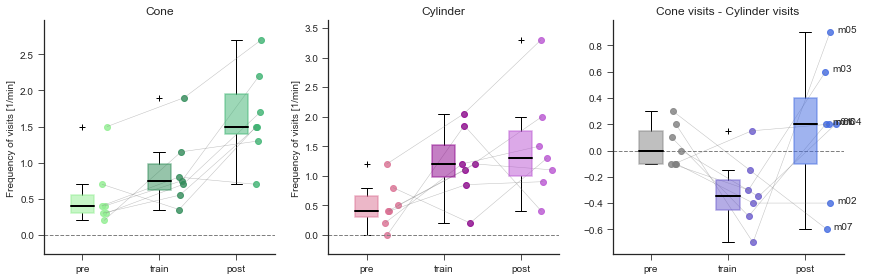

In [312]:
VisitFreq = [coneVisitFreq,cyliVisitFreq]
VisitFreqRatio = coneVisitFreq-cyliVisitFreq

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], objtype, VisitFreq[objtype],
                             flyIDs, offsets, plotLabels=False)

    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, objtype, VisitFreqRatio,flyIDs, offsets, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitFrequency_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

p = 0.612985058077
Plot directory already exists


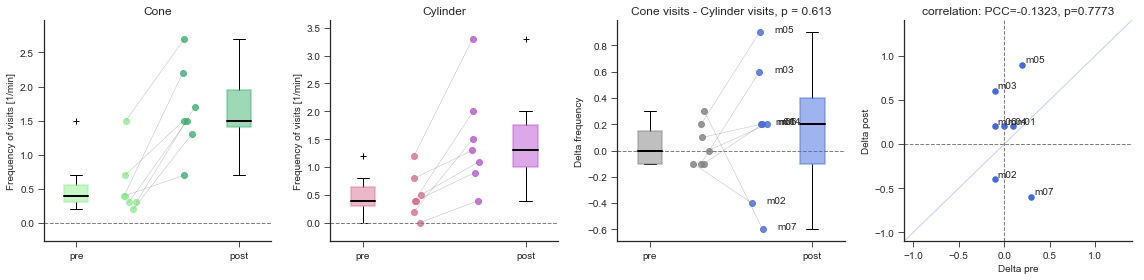

In [313]:
# compare just pre and post

VisitFreq = [coneVisitFreq[:,[0,2]],cyliVisitFreq[:,[0,2]]]
VisitFreqRatio = coneVisitFreq[:,[0,2]]-cyliVisitFreq[:,[0,2]]

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], objtype, VisitFreq[objtype],
                             flyIDs, offsets_pp, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, objtype, VisitFreqRatio, flyIDs, offsets_pp, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_ylabel('Delta frequency')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitFreqRatio[:,0], VisitFreqRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitFreqRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

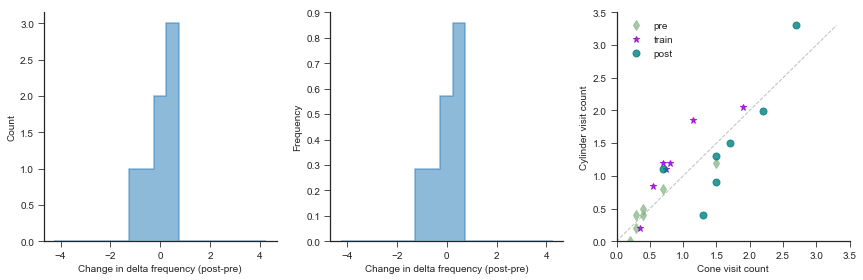

In [314]:
# Learning-induced shift in visit freuqency
histrange = (-4.25,4.25)
nbins = 17

normedvals = [False, True]
labelvals = ['Count','Frequency']

shiftFig = plt.figure(figsize=(12,4))
for i in range(2):
    shiftPlt = shiftFig.add_subplot(1,3,i+1)
    shiftPlt.hist(VisitFreqRatio[:,1]-VisitFreqRatio[:,0], range=histrange, bins=nbins, histtype = 'step',
                  normed=normedvals[i], fill=BoxColors_pp[-1],linewidth=1.5, align='mid', alpha=boxalpha)
    shiftPlt.set_xlabel('Change in delta frequency (post-pre)')
    shiftPlt.set_ylabel(labelvals[i])
    myAxisTheme(shiftPlt)
shiftFig.tight_layout()

#scatter plot of cone vs. cylinder visits per trial
for trial in range(3):
    prefPlt = shiftFig.add_subplot(1,3,3)
    prefPlt.plot(coneVisitFreq[:,trial], cyliVisitFreq[:,trial],markersize=7,
                 marker=trialMarkers[trial],linestyle='none', color=trialColors[trial], alpha=0.8)
#slct = (VisitFreqRatio[:,1]-VisitFreqRatio[:,0])>0
#prefPlt.plot(coneVisitFreq[slct,trial], cyliVisitFreq[slct,trial],
#                 marker='o',markersize=7,markerfacecolor='none',linestyle='none', color='black',alpha=0.8)
maxplt = np.nanmax((coneVisitFreq,cyliVisitFreq))
prefPlt.plot([0,maxplt],[0,maxplt],linewidth=1,color='grey',linestyle='dashed',alpha=0.5)
prefPlt.set_xlabel('Cone visit count')
prefPlt.set_ylabel('Cylinder visit count')
prefPlt.set_xlim(0,0.2+np.nanmax((coneVisitFreq,cyliVisitFreq)))
prefPlt.set_ylim(0,0.2+np.nanmax((coneVisitFreq,cyliVisitFreq)))
prefPlt.legend(trialName)
myAxisTheme(prefPlt)

shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePostHist_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### "Performance index" (PI)

Plot directory already exists


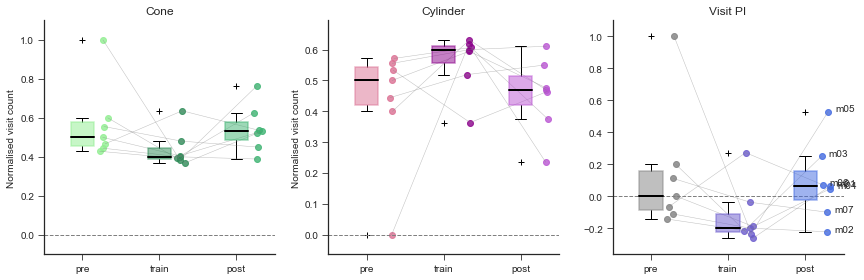

In [315]:
# Compute "PERFORMANCE INDEX" as [#cone - #cyli]/total #

VisitCount = [coneVisitCount,cyliVisitCount]
totalVisitCount = coneVisitCount+cyliVisitCount
totalVisitCount[np.where(totalVisitCount==0)] = np.nan
VisitPI = np.squeeze(VisitCount)/totalVisitCount
VisitPI[np.where(np.isnan(VisitPI))] = 0

VisitPIRatio = np.squeeze(coneVisitCount-cyliVisitCount)/totalVisitCount
VisitPIRatio[np.where(np.isnan(VisitPIRatio))] = 0

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], objtype, VisitPI[objtype],
                             flyIDs, offsets, plotLabels=False)

    bpPlt.set_ylabel('Normalised visit count')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, objtype, VisitPIRatio,flyIDs, offsets, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitPIRatio)+np.min(VisitPIRatio),
                0.1*np.max(VisitPIRatio)+np.max(VisitPIRatio)))
bpPlt.set_title('Visit PI')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitPI_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

p = 0.646463976894
Plot directory already exists


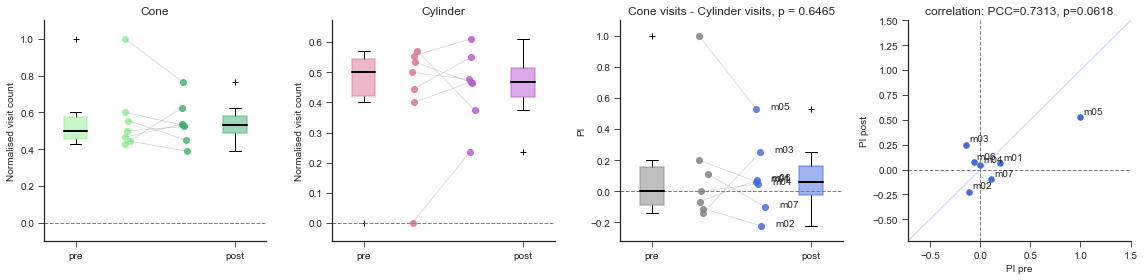

In [316]:
# compare just pre and post
VisitCount = [coneVisitCount[:,[0,2]],cyliVisitCount[:,[0,2]]]
totalVisitCount = coneVisitCount[:,[0,2]]+cyliVisitCount[:,[0,2]]
totalVisitCount[np.where(totalVisitCount==0)] = np.nan
VisitPI = np.squeeze(VisitCount)/totalVisitCount
VisitPI[np.where(np.isnan(VisitPI))] = 0

VisitPIRatio = np.squeeze(coneVisitCount[:,[0,2]]-cyliVisitCount[:,[0,2]])/totalVisitCount
VisitPIRatio[np.where(np.isnan(VisitPIRatio))] = 0

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], objtype, VisitPI[objtype],
                             flyIDs, offsets_pp, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Normalised visit count')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, objtype, VisitPIRatio, flyIDs, offsets_pp, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitPIRatio)+np.min(VisitPIRatio),
                0.1*np.max(VisitPIRatio)+np.max(VisitPIRatio)))
bpPlt.set_ylabel('PI')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitPIRatio[:,0], VisitPIRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitPIRatio, flyIDs, BoxColors_pp[-1])
bpPlt.set_xlabel('PI pre')
bpPlt.set_ylabel('PI post')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitPI_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

### Visit length

Plot directory already exists


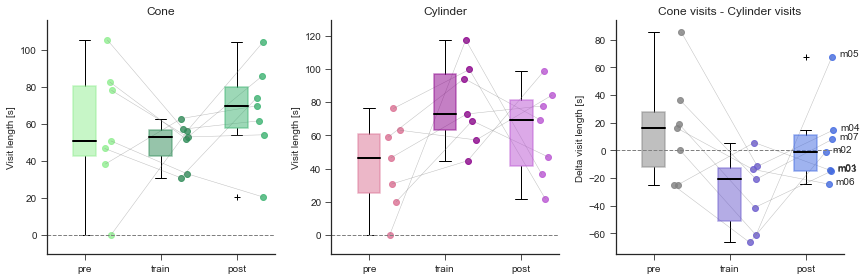

In [317]:
conelength = np.copy(coneVisitLength); cylilength = np.copy(cyliVisitLength)
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], objtype, VisitLength[objtype],
                             flyIDs, offsets, plotLabels=False)

    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, objtype, VisitLengthRatio,flyIDs, offsets, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitLengthRatio)+np.min(VisitLengthRatio),
                0.1*np.max(VisitLengthRatio)+np.max(VisitLengthRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
bpPlt.set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

p = 0.58335353268
Plot directory already exists


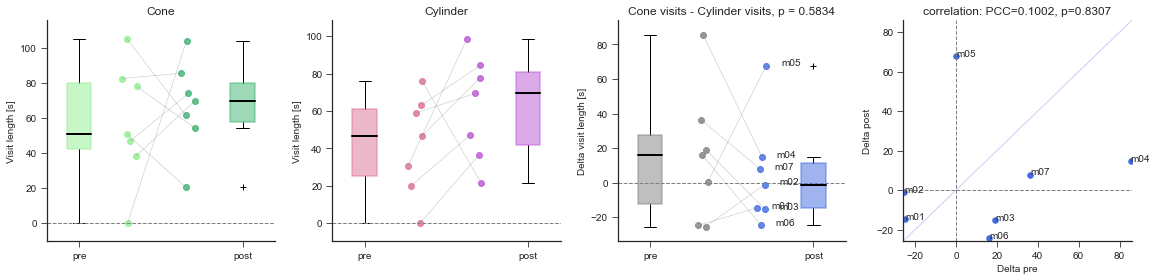

In [318]:
# compare just pre and post
conelength = np.copy(coneVisitLength[:,[0,2]]); cylilength = np.copy(cyliVisitLength[:,[0,2]])
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], objtype, VisitLength[objtype],
                             flyIDs, offsets_pp, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, objtype, VisitLengthRatio, flyIDs, offsets_pp, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitLengthRatio)+np.min(VisitLengthRatio),
                0.1*np.max(VisitLengthRatio)+np.max(VisitLengthRatio)))
bpPlt.set_ylabel('Delta visit length [s]')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitLengthRatio[:,0], VisitLengthRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitLengthRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                 +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

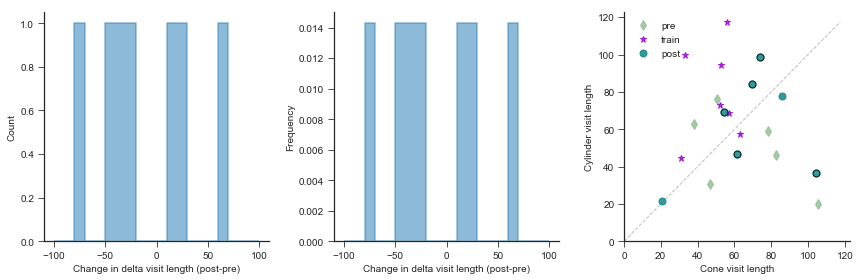

In [319]:
# Learning-induced shift in visit freuqency
histrange = (-100,100)
nbins = 20

normedvals = [False, True]
labelvals = ['Count','Frequency']

shiftFig = plt.figure(figsize=(12,4))
for i in range(2):
    shiftPlt = shiftFig.add_subplot(1,3,i+1)
    shiftPlt.hist(VisitLengthRatio[:,1]-VisitLengthRatio[:,0], range=histrange, bins=nbins, histtype = 'step',
                  normed=normedvals[i], fill=BoxColors_pp[-1],linewidth=1.5, align='mid', alpha=boxalpha)
    shiftPlt.set_xlabel('Change in delta visit length (post-pre)')
    shiftPlt.set_ylabel(labelvals[i])
    myAxisTheme(shiftPlt)
shiftFig.tight_layout()

#scatter plot of cone vs. cylinder visits per trial
slct = (VisitFreqRatio[:,1]-VisitFreqRatio[:,0])>0
for trial in range(3):
    prefPlt = shiftFig.add_subplot(1,3,3)
    prefPlt.plot(coneVisitLength[:,trial], cyliVisitLength[:,trial],markersize=7,
                 marker=trialMarkers[trial],linestyle='none', color=trialColors[trial], alpha=0.8)
    
prefPlt.plot(coneVisitLength[slct,trial], cyliVisitLength[slct,trial],
            marker=trialMarkers[trial],markersize=7,markerfacecolor='none',linestyle='none', color='black',alpha=0.8)

maxplt = np.nanmax((coneVisitLength,cyliVisitLength))
prefPlt.plot([0,maxplt],[0,maxplt],linewidth=1,color='grey',linestyle='dashed',alpha=0.5)
prefPlt.set_xlabel('Cone visit length')
prefPlt.set_ylabel('Cylinder visit length')
prefPlt.set_xlim(0,5+np.nanmax((coneVisitLength,cyliVisitLength)))
prefPlt.set_ylim(0,5+np.nanmax((coneVisitLength,cyliVisitLength)))
prefPlt.legend(trialName)
myAxisTheme(prefPlt)

shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_prePostHist_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                 +selectionTag+'.pdf', format='pdf')

### Cumsum visit plot

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in divide
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


Plot directory already exists


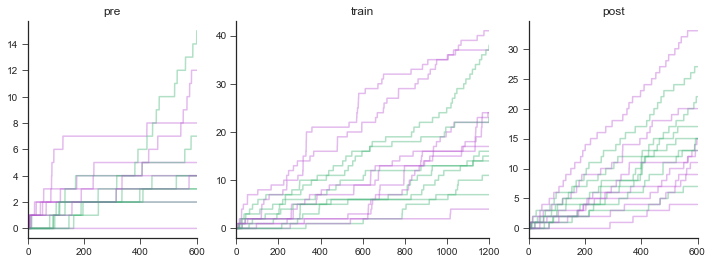

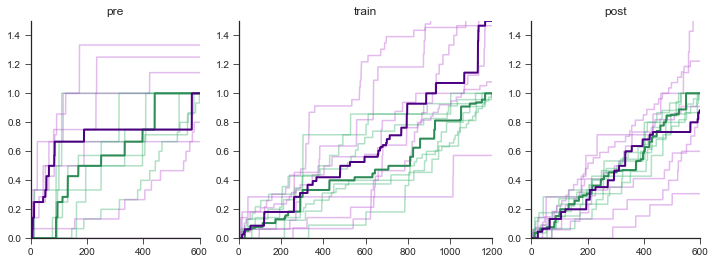

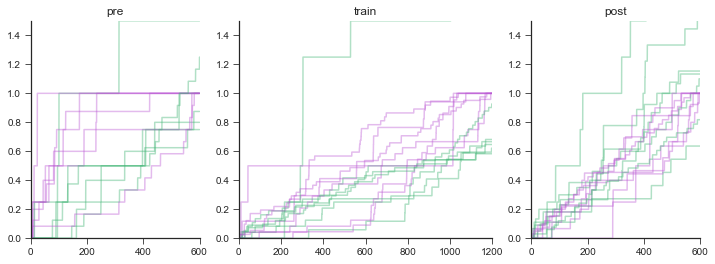

In [320]:
#NEEDS CLEAN UP

visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})
scaledVisitFig, scaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4),gridspec_kw = {'width_ratios':[1, 1.5, 1]})
revScaledVisitFig, revScaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})

vistitAlphaScale = [10,10,10]

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    scaledConeVisits = np.nan*np.ones((numFlies, len(timeTrial)))
    scaledCyliVisits = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):
        #if(coneVisitCount[fly,0] <10):
        #    continue

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
            
        alphaVal = 0.4#min(1.0,(sum(entriesCone)/vistitAlphaScale[trial]))

        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone),color='mediumseagreen', alpha=alphaVal)
        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli),color='mediumorchid', alpha=alphaVal)
        
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone)/sum(entriesCone),color='mediumseagreen', alpha=alphaVal)
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli)/sum(entriesCone),color='mediumorchid', alpha=alphaVal)
        
        scaledConeVisits[fly,:] = np.cumsum(entriesCone)/sum(entriesCone)
        scaledCyliVisits[fly,:] = np.cumsum(entriesCyli)/sum(entriesCone)
        
        #reverse scale
        revScaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone)/sum(entriesCyli),color='mediumseagreen', alpha=alphaVal)
        revScaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli)/sum(entriesCyli),color='mediumorchid', alpha=alphaVal)
        
    cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitPlts[trial])
    cumsumVisitPlts[trial].set_title(trialtype)

    scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledConeVisits,axis=0),
                                      color = 'seagreen',linewidth=2)
    scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledCyliVisits,axis=0),
                                      color = 'indigo',linewidth=2)
    myAxisTheme(scaledCumsumVisitPlts[trial])
    scaledCumsumVisitPlts[trial].set_title(trialtype)
    scaledCumsumVisitPlts[trial].set_ylim(0,1.5)

    revScaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(revScaledCumsumVisitPlts[trial])
    revScaledCumsumVisitPlts[trial].set_title(trialtype)
    revScaledCumsumVisitPlts[trial].set_ylim(0,1.5)    
        
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
revScaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_cyliScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


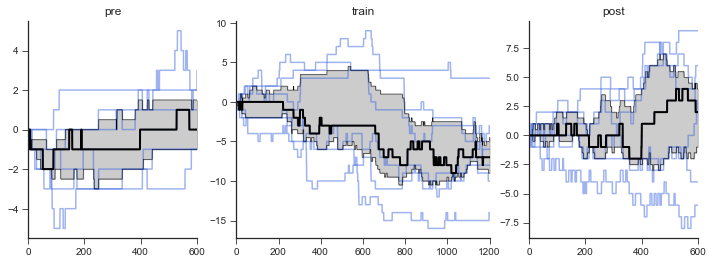

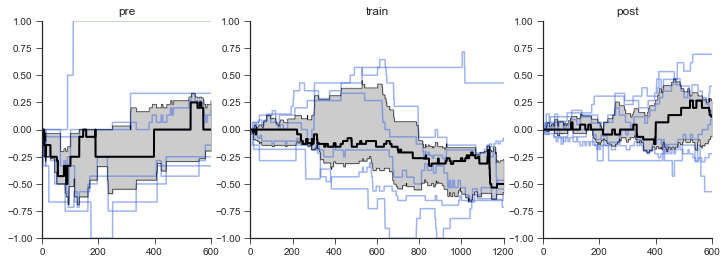

In [321]:
visitDiffFig, cumsumVisitDiffPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})
scaledVisitDiffFig, scaledCumsumVisitDiffPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[1, 1.5, 1]})

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    visitDiff = np.nan*np.ones((numFlies, len(timeTrial)))
    visitDiffNorm = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()


        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
        
        #if(entriesCone+entriesCyli < 5):
        #    continue

        visitDiff[fly] = np.cumsum(entriesCone)-np.cumsum(entriesCyli)
        visitDiffNorm[fly] = np.cumsum(entriesCone)/sum(entriesCone) - np.cumsum(entriesCyli)/sum(entriesCone)
            
        #alphaVal = min(1.0,(sum(entriesCone)/vistitAlphaScale[trial]))

        cumsumVisitDiffPlts[trial].plot(timeTrial,visitDiff[fly],color=BoxColors_pp[-1], alpha=0.5)
        
        scaledCumsumVisitDiffPlts[trial].plot(timeTrial,visitDiffNorm[fly] ,color=BoxColors_pp[-1], alpha=0.5)
    
    av = np.nanmedian(visitDiff,axis=0)
    [var1,var2] = np.nanpercentile(visitDiff, [25,75], axis=0)
    cumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    av = np.nanmedian(visitDiffNorm,axis=0)
    [var1,var2] = np.nanpercentile(visitDiffNorm,[25,75], axis=0)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    cumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitDiffPlts[trial])
    cumsumVisitDiffPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitDiffPlts[trial])
    scaledCumsumVisitDiffPlts[trial].set_title(trialtype)
    scaledCumsumVisitDiffPlts[trial].set_ylim(-1,1)
        
visitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     +selectionTag+'.pdf', format='pdf')
scaledVisitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_scaledCumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                           +selectionTag+'.pdf', format='pdf')

## Effect of repeated reward on movement

### Quantify the effect of the total amount of reward a fly experienced on movement patterns


In [322]:
rewardT = np.zeros(len(flyIDs))
vTrans = np.zeros((len(flyIDs),len(trialName)))
vRot = np.zeros((len(flyIDs),len(trialName)))

for fly in range(len(flyIDs)):
    querystring = '(trialtype=="train") & (flyID == "'+flyIDs[fly]+'")'
    evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()
    rewardT[fly] = np.sum(np.sign(evTrial))/fps
    
for fly in range(len(flyIDs)):
    for trial in range(3):
        querystring = '(trialtype=="'+trialName[trial]+'") & (flyID == "'+flyIDs[fly]+'")'
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
        perFlymov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].values.squeeze()

        tSt = 0#(5*len(timeTrial))/10.0
        tEnd = len(timeTrial)
        vt = perFlyvT[tSt:tEnd]
        vr = perFlyvR[tSt:tEnd]
        mov = perFlymov.astype('bool')[tSt:tEnd] 
        vTrans[fly,trial] = np.squeeze(np.nanmedian(vt[mov]))
        vRot[fly,trial] = np.squeeze(np.nanmedian(abs(vr[mov])))

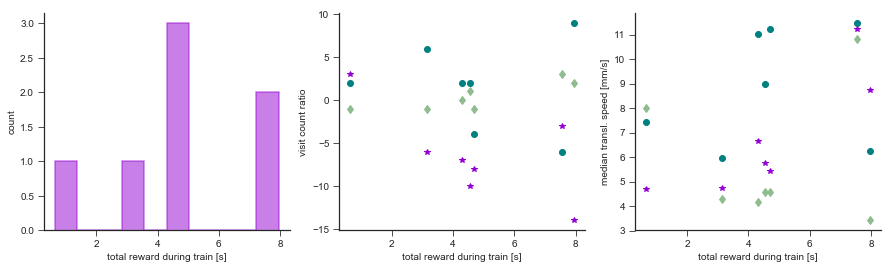

In [323]:
rewardExpFig, rewardExpPlts = plt.subplots(1,3, figsize=(15,4))

rewardExpPlts[0].hist(rewardT,fill=True, color=trialColors[1], alpha=boxalpha, histtype = 'step',
                      linewidth=1.5, align='mid')
rewardExpPlts[0].set_xlabel('total reward during train [s]')
rewardExpPlts[0].set_ylabel('count')
myAxisTheme(rewardExpPlts[0])

for trial in range(3):
    VisitCountRatio = coneVisitCount[:,trial]-cyliVisitCount[:,trial]
    rewardExpPlts[1].plot(rewardT,VisitCountRatio,marker=trialMarkers[trial],
                          linestyle='none', color=trialColors[trial])
rewardExpPlts[1].set_xlabel('total reward during train [s]')
rewardExpPlts[1].set_ylabel('visit count ratio')
myAxisTheme(rewardExpPlts[1])

for trial in range(3):
    rewardExpPlts[2].plot(rewardT,vTrans[:,trial],marker=trialMarkers[trial],
                          linestyle='none', color=trialColors[trial])
rewardExpPlts[2].set_xlabel('total reward during train [s]')
rewardExpPlts[2].set_ylabel('median transl. speed [mm/s]')
myAxisTheme(rewardExpPlts[2])

rewardExpFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_totalRewardCorr_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     + selectionTag+'.pdf', format='pdf')

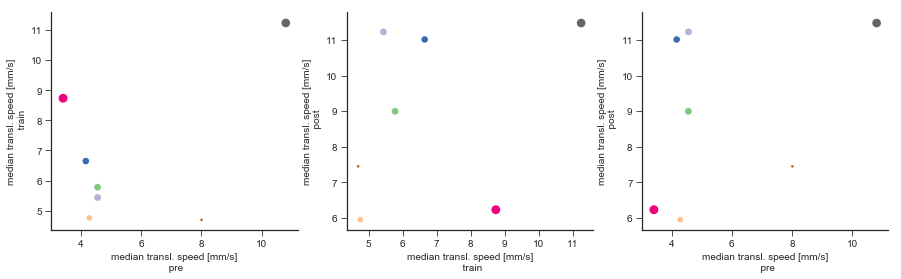

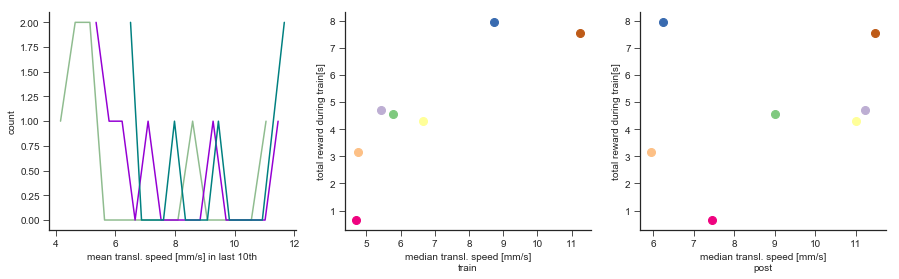

In [324]:
rewardExpFig, rewardExpPlts = plt.subplots(1,3, figsize=(15,4))

sizefact = 10

rewardExpPlts[0].scatter(vTrans[:,0],vTrans[:,1],s=rewardT*sizefact,c=range(numFlies),cmap='Accent',edgecolor='none')
rewardExpPlts[0].set_xlabel('median transl. speed [mm/s]\n pre')
rewardExpPlts[0].set_ylabel('median transl. speed [mm/s]\n  train')
myAxisTheme(rewardExpPlts[0])

rewardExpPlts[1].scatter(vTrans[:,1],vTrans[:,2],s=rewardT*sizefact,c=range(numFlies),cmap='Accent',edgecolor='none')
rewardExpPlts[1].set_xlabel('median transl. speed [mm/s]\n  train')
rewardExpPlts[1].set_ylabel('median transl. speed [mm/s]\n  post')
myAxisTheme(rewardExpPlts[1])

rewardExpPlts[2].scatter(vTrans[:,0],vTrans[:,2],s=rewardT*sizefact,c=range(numFlies),cmap='Accent',edgecolor='none')
rewardExpPlts[2].set_xlabel('median transl. speed [mm/s]\n  pre')
rewardExpPlts[2].set_ylabel('median transl. speed [mm/s]\n  post')
myAxisTheme(rewardExpPlts[2])


rewardExpFig, rewardExpPlts = plt.subplots(1,3, figsize=(15,4))

trialCols = ['grey','darkred','tomato']
markerSize = 8

for trial in range(3):
    n,edges = np.histogram(vTrans[:,trial],bins=15)
    rewardExpPlts[0].plot(edges[1:]+np.mean(np.diff(edges))/2,n,color=trialColors[trial])
    rewardExpPlts[0].set_xlabel('mean transl. speed [mm/s] in last 10th')
    rewardExpPlts[0].set_ylabel('count')
    myAxisTheme(rewardExpPlts[0])
    
    if trial==0:
        continue
    
    for fly in range(len(flyIDs)):
        rewardExpPlts[trial].plot(vTrans[fly,trial],rewardT[fly],'o',markersize=markerSize,color=flyCMap.to_rgba(fly))
        rewardExpPlts[trial].set_xlabel('median transl. speed [mm/s]\n'+ trialName[trial])
        rewardExpPlts[trial].set_ylabel('total reward during train[s]')
        myAxisTheme(rewardExpPlts[trial])

### Generate frames for trace movie

In [12]:
import matplotlib.patches as patches

def plotBodyAngle(ax, x, y, angle, markerColor, alphaVal, arrowScale):
    #try:
    newArrow = patches.FancyArrow(x, y, np.cos(angle).squeeze()*arrowScale, np.sin(angle).squeeze()*arrowScale,
                                  width=0.25, head_width=0.25,
                                  edgecolor=markerColor, facecolor=markerColor, alpha=alphaVal)
    ax.add_patch(newArrow)
    #except:
    #    print("could not draw arrow")

In [13]:
visitRad = 15

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

cyliColor = 'darkblue'
coneColor = 'darkred'

        
fly=1
trial = 0

trialtype =trialName[trial]

querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
angleFly = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()
timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

count=0

for frame in range(11*20*60,12*20*60):#int(len(timeTrial)*0.1)):
    frameName = str(frame)
    
    visitFig = plt.figure(figsize=(5,5))
    visitPlt = visitFig.add_subplot(111)
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    visitPlt.plot(xpos,ypos,'.',color='black',markersize=11,alpha=0.6)
    plotBodyAngle(visitPlt, xpos, ypos, angleFly[frame],'black', 0.6, 5)

    if(entriesCone[frame]>0):
        visitPlt.plot(xpos,ypos,'ro',markersize=10,)
    
    if(entriesCyli[frame]>0):
        visitPlt.plot(xpos,ypos,'bo',markersize=10)
        
    if(evTrial[frame]>0):
        visitPlt.plot(xpos,ypos,'.',markersize=14,color='darkred')

    visitPlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=11, alpha=0.8, color=cyliColor)
    visitPlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=14, alpha=0.8, color=coneColor)
    visitPlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=14, alpha=0.8, color=coneColor)
    visitPlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=11, alpha=0.8, color=cyliColor)

    visitPlt.set_xlim(0,120)
    visitPlt.set_ylim(-60,60)
    visitPlt.set_aspect('equal')
    
    visitPlt.set_title(trialtype)
    myAxisTheme(visitPlt)
    

    try:
        mkdir(analysisDir + 'movieMaterial/')
    except:
        count=count+1
        
    visitFig.savefig(analysisDir + 'movieMaterial/'+ genotype +'_'+flyIDs[0][0]
                       +'_collapsedTrace_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.png', format='png')
    
    
    plt.close("all")

### Velocity and relative heading distributions

In [ ]:
#for ttind,trialtype in enumerate(visibilityState):
#    
#    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
#    veloDistFig.tight_layout()
#    
#    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
#                + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

In [ ]:
#for ttind,trialtype in enumerate(visibilityState):
#    
#    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
#    veloDistFig.tight_layout()
#
#    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
#                + '_veloDistributions2_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')